In [51]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os
import time
from tqdm import tqdm

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()


# Ignore useless warnings (see SciPy issue #5998)
# import warnings
# warnings.filterwarnings(action="ignore", message="^internal gelsd")


# ...
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
# from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# from sklearn import metrics
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix


# import category_encoders as ce
# from category_encoders import BinaryEncoder

In [2]:
# Paths ...
PATH_TO_DATA_DIR = os.path.join('..', '..', '..', 'Data')

# ...
ADASYB_DATASET_TRAIN = os.path.join(PATH_TO_DATA_DIR, 'Adasyn_train.csv')
ADASYB_DATASET_TEST = os.path.join(PATH_TO_DATA_DIR, 'Adasyn_test.csv')

PATH_TO_DATA_DIR

'..\\..\\..\\Data'

In [3]:
df_train = pd.read_csv(ADASYB_DATASET_TRAIN)
df_train.head(3)

,PatientId,Gender,Age,Neighbourhood_0,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,...,DayAppointmentDate_3,DayAppointmentDate_4,DayAppointmentDate_5,HourOfDayBooking_0,DaysToAppointment,AppointmentWeekDay_0,AppointmentWeekDay_1,AppointmentWeekDay_2,AppointmentWeekDay_3,NoShow
0,4652519881919,0,8,0,0,0,1,0,1,1,...,0,1,0,1,1,0,0,1,0,0
1,81431485833737,0,74,0,0,1,0,1,0,0,...,0,0,1,1,12,0,0,1,1,0
2,555956674526286,0,50,0,0,1,0,1,0,1,...,0,0,1,1,31,0,0,0,1,0


In [4]:
X_train = df_train.loc[:, df_train.columns != 'NoShow'] 
y_train = df_train[['NoShow']].values

X_train.shape, y_train.shape

((123381, 42), (123381, 1))

In [5]:
df_test = pd.read_csv(ADASYB_DATASET_TEST)
df_test.head(3)

,PatientId,Gender,Age,Neighbourhood_0,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,...,DayAppointmentDate_3,DayAppointmentDate_4,DayAppointmentDate_5,HourOfDayBooking_0,DaysToAppointment,AppointmentWeekDay_0,AppointmentWeekDay_1,AppointmentWeekDay_2,AppointmentWeekDay_3,NoShow
0,836957433187,0,7,0,0,0,1,0,1,1,...,0,0,1,1,46,0,0,1,1,1
1,791415392462,0,27,0,0,0,1,1,1,1,...,1,1,0,1,0,0,0,0,1,0
2,4131646379876,0,47,0,0,0,1,0,1,1,...,1,1,0,1,1,0,0,1,0,1


In [6]:
X_test = df_test.loc[:, df_train.columns != 'NoShow'] 
y_test = df_test[['NoShow']].values

X_test.shape, y_test.shape

((34937, 42), (34937, 1))

## Utils

In [7]:
def plot_hist(dataFrame, feature, title='Histogram'):
    sns.set(style="ticks", color_codes=True)
    sns.distplot(dataFrame[feature], color='red', kde=False, bins=5)

    plt.title(title)
    plt.xlim(-0.5, 1.5)
    plt.tight_layout();

    # plt.savefig('./imgs/barplot_price_bin.png', dpi=300);

## Preprocessing

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123381 entries, 0 to 123380
Data columns (total 43 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   PatientId               123381 non-null  int64
 1   Gender                  123381 non-null  int64
 2   Age                     123381 non-null  int64
 3   Neighbourhood_0         123381 non-null  int64
 4   Neighbourhood_1         123381 non-null  int64
 5   Neighbourhood_2         123381 non-null  int64
 6   Neighbourhood_3         123381 non-null  int64
 7   Neighbourhood_4         123381 non-null  int64
 8   Neighbourhood_5         123381 non-null  int64
 9   Neighbourhood_6         123381 non-null  int64
 10  Neighbourhood_7         123381 non-null  int64
 11  Scholarship             123381 non-null  int64
 12  Hypertension            123381 non-null  int64
 13  Diabetes                123381 non-null  int64
 14  Alcoholism              123381 non-null  int64
 15  

In [9]:
df_train.describe()

,PatientId,Gender,Age,Neighbourhood_0,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,...,DayAppointmentDate_3,DayAppointmentDate_4,DayAppointmentDate_5,HourOfDayBooking_0,DaysToAppointment,AppointmentWeekDay_0,AppointmentWeekDay_1,AppointmentWeekDay_2,AppointmentWeekDay_3,NoShow
count,1.233810e+05,123381.000000,123381.000000,123381.0,123381.000000,123381.000000,123381.000000,123381.000000,123381.000000,123381.000000,...,123381.000000,123381.000000,123381.000000,123381.0,123381.000000,123381.0,123381.000000,123381.000000,123381.000000,123381.000000
mean,1.468649e+14,0.269239,35.969477,0.0,0.070529,0.252446,0.376306,0.370762,0.384532,0.478258,...,0.409058,0.444785,0.410938,1.0,12.147964,0.0,0.298920,0.349689,0.446925,0.498132
std,2.552446e+14,0.443566,21.443056,0.0,0.256038,0.434417,0.484460,0.483011,0.486487,0.499529,...,0.491662,0.496944,0.492006,0.0,14.829341,0.0,0.457786,0.476874,0.497177,0.499999
min,3.921700e+04,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,4.212193e+12,0.000000,19.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,3.165008e+13,0.000000,35.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.0,7.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,9.438855e+13,1.000000,52.000000,0.0,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.0,19.000000,0.0,1.000000,1.000000,1.000000,1.000000
max,9.999816e+14,1.000000,115.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.0,179.000000,0.0,1.000000,1.000000,1.000000,1.000000


c:\worspace\python\venv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


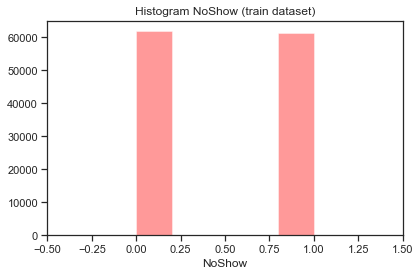

In [10]:
plot_hist(df_train, 'NoShow', title='Histogram NoShow (train dataset)')

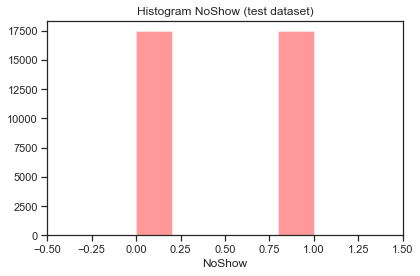

In [11]:
plot_hist(df_test, 'NoShow', title='Histogram NoShow (test dataset)')

In [12]:
number_of_all_rows = df_train.shape[0]
number_of_patient = df_train['PatientId'].value_counts().shape[0]

number_of_all_rows, number_of_patient

(123381, 92377)

In [13]:
df_train['PatientId'].value_counts()

99637671331        65
822145925426128    63
26886125921145     53
258424392677       47
871374938638855    47
                   ..
773721544671816     1
323327834217463     1
748782826973263     1
746599523281        1
9251376286330       1
Name: PatientId, Length: 92377, dtype: int64

In [14]:
# https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf
# https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976
# https://iaml.it/blog/optimizing-sklearn-pipelines


# ...
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
numeric_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [15]:
# ...
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

In [16]:
processing_full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", numeric_transformer),
#     ("cat_pipeline", categorical_transformer),
])
processing_full_pipeline

FeatureUnion(transformer_list=[('num_pipeline',
                                Pipeline(steps=[('imputer',
                                                 SimpleImputer(strategy='median')),
                                                ('scaler',
                                                 StandardScaler())]))])

## Fitting the classifier

In [17]:
full_pipeline_ = Pipeline(
    steps = [ 
        ('processing_full_pipeline', processing_full_pipeline),
        ('classifier', LogisticRegression() ) 
    ]
)

full_pipeline_

Pipeline(steps=[('processing_full_pipeline',
                 FeatureUnion(transformer_list=[('num_pipeline',
                                                 Pipeline(steps=[('imputer',
                                                                  SimpleImputer(strategy='median')),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('classifier', LogisticRegression())])

In [18]:
_ = full_pipeline_.fit(X_train, y_train)

c:\worspace\python\venv\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [19]:
train_score = full_pipeline_.score(X_train, y_train)
test_score = full_pipeline_.score(X_test, y_test)

print('Train accuracy: {}%'.format(round(train_score * 100, 2)))
print('Test accuracy: {}%'.format(round(test_score * 100, 2)))

Train accuracy: 82.1%
Test accuracy: 82.36%


In [20]:
y_pred = full_pipeline_.predict(X_test)
y_pred

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

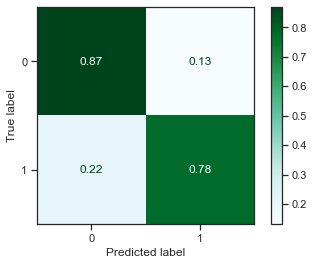

In [21]:
plot_confusion_matrix(
    full_pipeline_, 
    X_test,
    y_test,
    cmap="BuGn",
    normalize='true',
#     ax=ax6
);

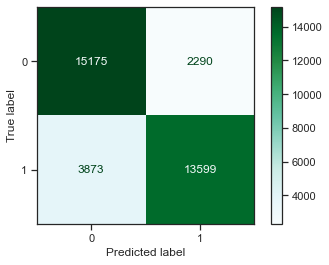

In [22]:
plot_confusion_matrix(
    full_pipeline_, 
    X_test,
    y_test,
    cmap="BuGn",
#     normalize='true',
#     ax=ax6
);

c:\worspace\python\venv\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression()
model train score: 0.821
model test score: 0.824
precision score:  0.856
recall score:  0.778
f1 score:  0.815
DecisionTreeClassifier()
model train score: 0.998
model test score: 0.802
precision score:  0.804
recall score:  0.798
f1 score:  0.801


c:\worspace\python\venv\lib\site-packages\sklearn\pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


RandomForestClassifier()
model train score: 0.998
model test score: 0.859
precision score:  0.916
recall score:  0.791
f1 score:  0.849


c:\worspace\python\venv\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


AdaBoostClassifier()
model train score: 0.814
model test score: 0.815
precision score:  0.813
recall score:  0.819
f1 score:  0.816


c:\worspace\python\venv\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GradientBoostingClassifier()
model train score: 0.840
model test score: 0.840
precision score:  0.884
recall score:  0.783
f1 score:  0.831
Wall time: 58.1 s


,name,train_score,test_score,precision_score,recall_score,f1_score
0,LogisticRegression,0.821010,0.823597,0.856,0.778,0.815
1,DecisionTreeClassifier,0.998436,0.801586,0.804,0.798,0.801
2,RandomForestClassifier,0.998420,0.859032,0.916,0.791,0.849
3,AdaBoostClassifier,0.814129,0.815267,0.813,0.819,0.816
4,GradientBoostingClassifier,0.840032,0.840284,0.884,0.783,0.831


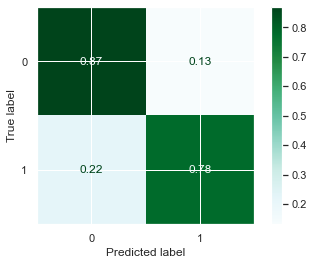

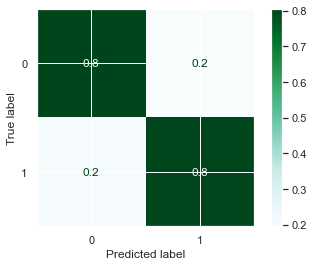

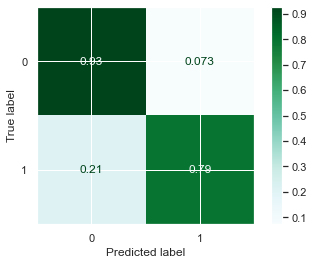

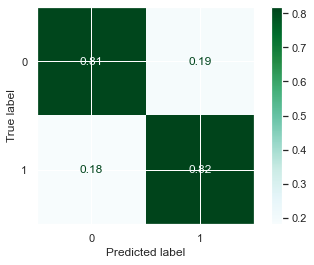

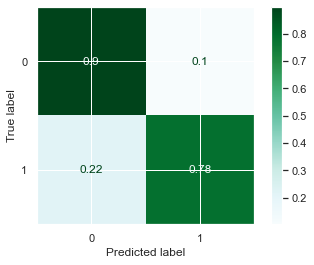

In [57]:
%%time

df_models_performence = []
classifiers = [
    LogisticRegression(),
    #KNeighborsClassifier(4),  # Take too long time at this moment
    #SVC(kernel="rbf", C=0.025, probability=True), # Take too long time at this moment
    #NuSVC(probability=True), # Take too long time at this moment
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
]


for classifier in classifiers:
    # ...
    pipe = Pipeline(steps = [ 
            ('processing_full_pipeline', processing_full_pipeline),
            ('classifier', classifier) 
        ]
    )
    # ...
    pipe.fit(X_train, y_train)

    # ...
    y_pred_ = pipe.predict(X_test)
    train_score = pipe.score(X_train, y_train)
    test_score = pipe.score(X_test, y_test)
    precision_score_ = round(precision_score(y_test.T[0], y_pred_), 3)
    recall_score_ = round(recall_score(y_test.T[0], y_pred_), 3)
    f1_score_ = round(f1_score(y_test.T[0], y_pred_), 3)

    # ...
    df_models_performence.append({
        'name': type(classifier).__name__,
        'train_score': train_score,
        'test_score': test_score,
        'precision_score': precision_score_,
        'recall_score': recall_score_,
        'f1_score': f1_score_,
    })

    # ...
    print('='*50)
    print(classifier)
    print("model train score: %.3f" % train_score)
    print("model test score: %.3f" % test_score)
    print('precision score: ', precision_score_)
    print('recall score: ', recall_score_)
    print('f1 score: ', f1_score_)
    plot_confusion_matrix(
        pipe, 
        X_test,
        y_test,
        cmap="BuGn",
        normalize='true',
        #ax=ax6
    );
    print('='*50)

    

df_models_performence = pd.DataFrame(df_models_performence)
df_models_performence

In [58]:
df_models_performence

,name,train_score,test_score,precision_score,recall_score,f1_score
0,LogisticRegression,0.821010,0.823597,0.856,0.778,0.815
1,DecisionTreeClassifier,0.998436,0.801586,0.804,0.798,0.801
2,RandomForestClassifier,0.998420,0.859032,0.916,0.791,0.849
3,AdaBoostClassifier,0.814129,0.815267,0.813,0.819,0.816
4,GradientBoostingClassifier,0.840032,0.840284,0.884,0.783,0.831
